# **Models using 1st set of features: Timestamp, Temperature, Start of Sem**

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Read in data
df = pd.read_csv('gym_data.csv')
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [ ]:
# Prep data with number of people as our dependent variable y
X = df.iloc[:,2:14]
y = df.iloc[:,0]

In [ ]:
# Use chi-squared score to identify best variables for predictive model
# Reference: https://365datascience.com/tutorials/python-tutorials/predictive-model-python/
best_features = SelectKBest(score_func=chi2, k=3)
fit = best_features.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

features_scores = pd.concat([df_columns, df_scores], axis=1)
features_scores.columns = ['Features', 'Score']
features_scores.sort_values(by = 'Score')

,Features,Score
3,is_holiday,2.616867e+02
2,is_weekend,1.800377e+03
7,month,1.926553e+03
1,day_of_week,2.840166e+03
6,is_during_semester,2.892081e+03
5,is_start_of_semester,2.930906e+03
4,temperature,6.834303e+03
8,hour,8.079652e+04
0,timestamp,2.788947e+08


In [ ]:
# Filter to 3 most important variables based on above scores and previous EDA
# Use only timestamp since timestamp = hour
X = df[['timestamp', 'temperature', 'is_start_of_semester']]
y = df['number_people']

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)

In [ ]:
# Split data to train and test set 80:20
X_train,X_test,y_train,y_test=train_test_split(X_rescaled,y,test_size=0.2,random_state=100)

In [ ]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

Test MSE: 307.76472140184103
Train MSE: 307.64277757637916


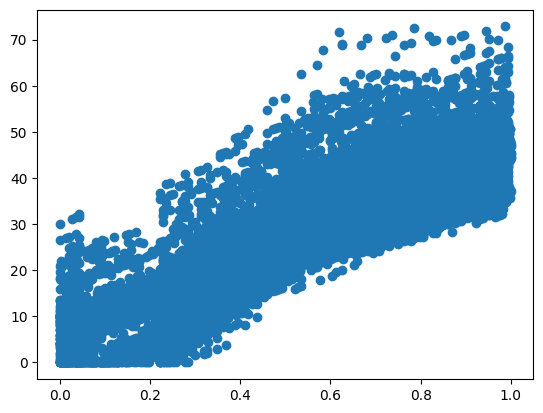

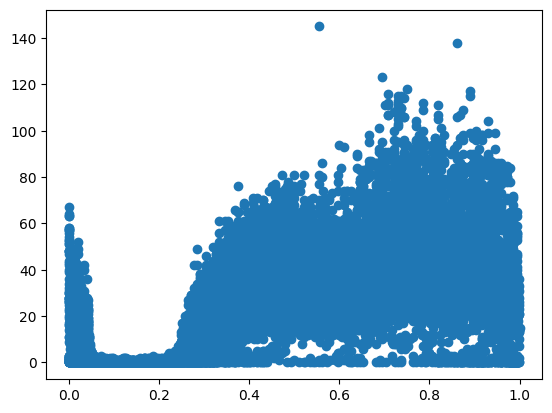

In [ ]:
# Get predictions
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print('Test MSE:',mean_squared_error(y_test, y_test_pred))
print('Train MSE:',mean_squared_error(y_train, y_train_pred))

# Change negative predictions to 0, there cannot be negative people at the gym
y_test_pred[y_test_pred < 0] = 0
y_train_pred[y_train_pred < 0 ] = 0

# Plot
plt.scatter(X_test['timestamp'],y_test_pred)
plt.show()

# Compare to actual data
plt.scatter(X_test['timestamp'],y_test)

Test MSE (degree 2): 284.603930088512641
Train MSE (degree 2): 284.236683162754161


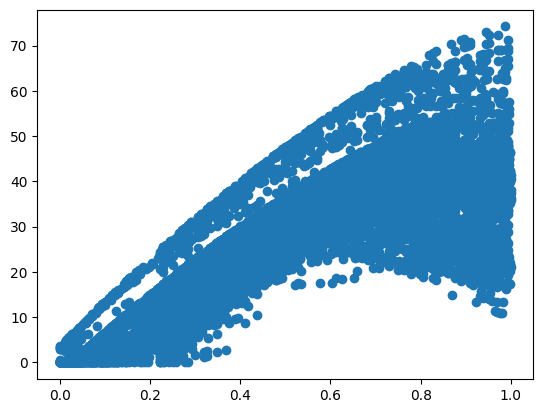

Test MSE (degree 3): 259.796814514966570
Train MSE (degree 3): 259.456323674419309


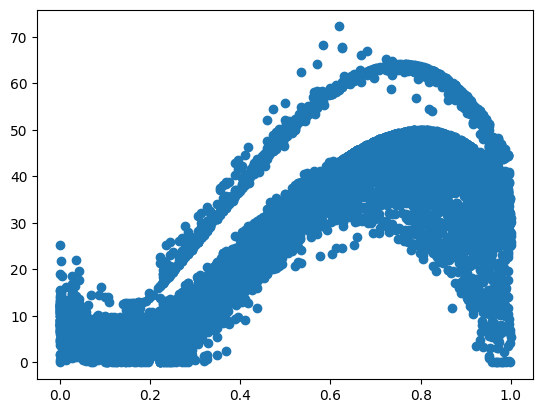

Test MSE (degree 4): 255.152856996880416
Train MSE (degree 4): 253.825811408260648


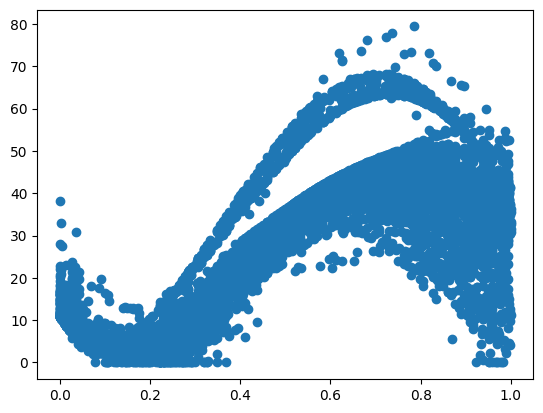

Test MSE (degree 5): 236.932103593774855
Train MSE (degree 5): 236.023393235417132


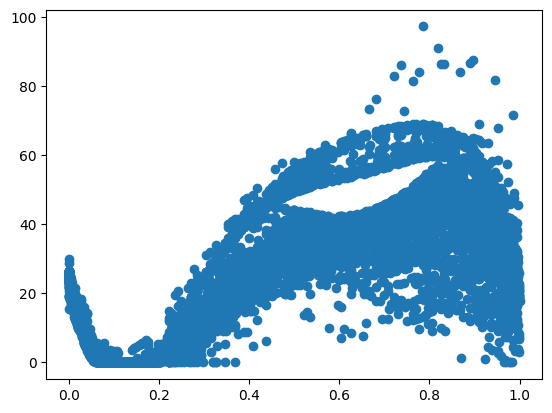

Test MSE (degree 6): 234.699747733510918
Train MSE (degree 6): 233.061179058441866


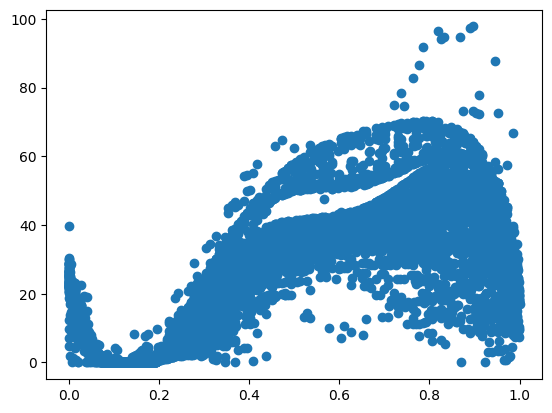

Test MSE (degree 7): 232.427417234534488
Train MSE (degree 7): 230.367461727573840


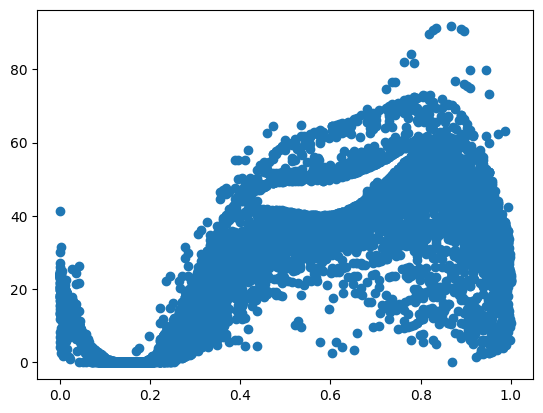

Test MSE (degree 8): 230.352102677930390
Train MSE (degree 8): 228.126310239997053


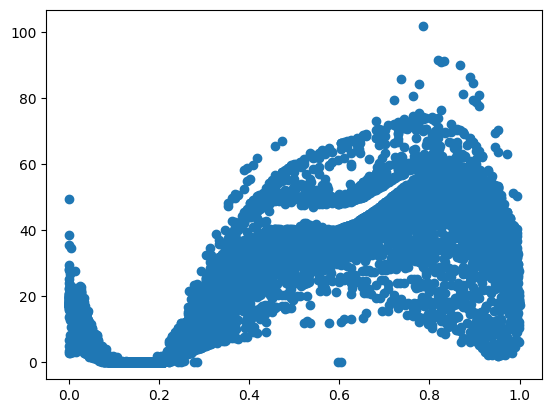

Test MSE (degree 9): 224.503788844991703
Train MSE (degree 9): 223.552011858352046


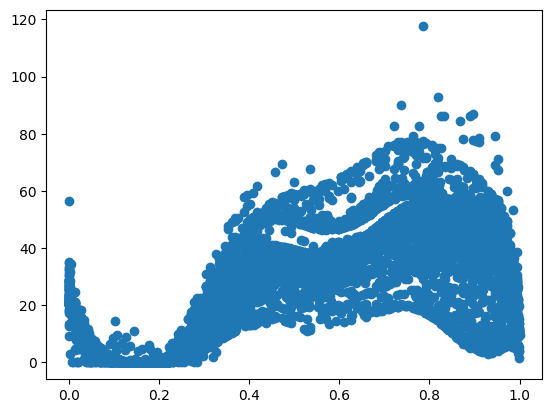

Test MSE (degree 10): 222.359019996843301
Train MSE (degree 10): 221.212749861520564


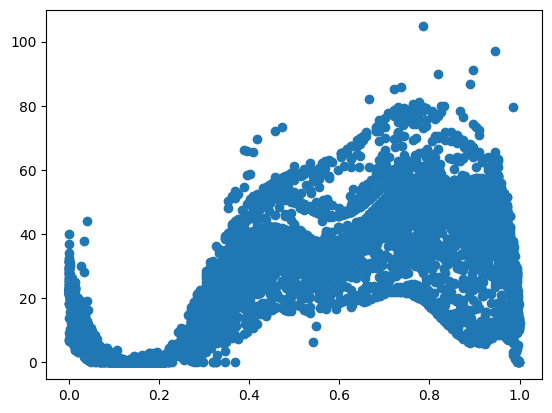

In [ ]:
# Polynomial Regression
for i in range(2,11):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(X_train)

    model = LinearRegression()

    model.fit(X_poly, y_train)

    y_train_pred = model.predict(poly.transform(X_train))
    y_test_pred = model.predict(poly.transform(X_test))

    y_test_pred[y_test_pred < 0] = 0
    y_train_pred[y_train_pred < 0 ] = 0

    print('Test MSE (degree '+str(i)+'): %8.15f' % mean_squared_error(y_test, y_test_pred))
    print('Train MSE (degree '+str(i)+'): %8.15f' % mean_squared_error(y_train, y_train_pred))

    plt.scatter(X_test['timestamp'],y_test_pred)
    plt.show()

In [ ]:
# Randomized search for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

mlp = MLPRegressor()

param_vals = {'max_iter': [300,500,700],
              'learning_rate_init': [0.01, 0.02, 0.03]}

random_rf = RandomizedSearchCV(estimator=mlp, param_distributions=param_vals,
                              n_iter=10, scoring='neg_mean_squared_error')

random_rf.fit(X_rescaled,y)

# Get optimal hyperparameters and minimum MSE achieved using this set of optimal hyperparameters
print(random_rf.best_estimator_)
print(-1*random_rf.best_score_)

MLPRegressor(learning_rate_init=0.03, max_iter=500)
316.7571198513032


Test MSE: 242.34249722216214
Train MSE: 242.1782469384702


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


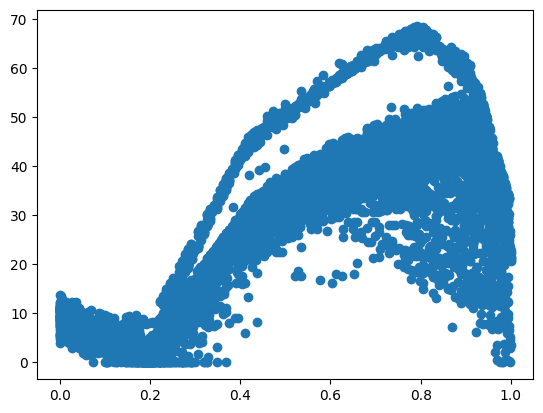

In [ ]:
# Neural Network
# Default hyperparameters
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

y_test_pred_nn = mlp.predict(X_test)
y_train_pred_nn = mlp.predict(X_train)

# Change all predictions less than 0 to be 0
y_test_pred_nn[y_test_pred_nn < 0] = 0
y_train_pred_nn[y_train_pred_nn < 0 ] = 0

print('Test MSE:',mean_squared_error(y_test, y_test_pred_nn))
print('Train MSE:',mean_squared_error(y_train, y_train_pred_nn))

plt.scatter(X_test['timestamp'],y_test_pred_nn)

Test MSE: 236.79866166473104
Train MSE: 235.22722041446565


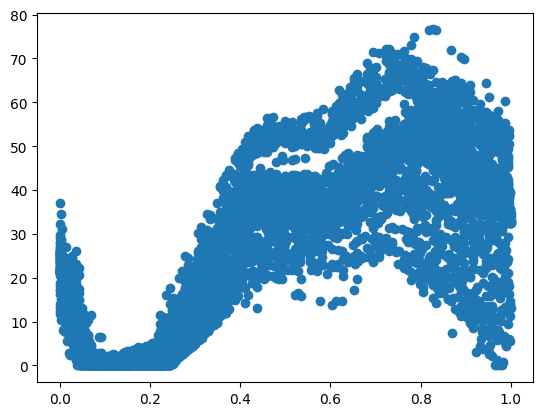

In [ ]:
# Neural Network
# With random search tuned hyperparameters
mlp = MLPRegressor(learning_rate_init = 0.03, max_iter=500)
mlp.fit(X_train, y_train)

y_test_pred_nn = mlp.predict(X_test)
y_train_pred_nn = mlp.predict(X_train)

# Change all predictions less than 0 to be 0
y_test_pred_nn[y_test_pred_nn < 0] = 0
y_train_pred_nn[y_train_pred_nn < 0 ] = 0

print('Test MSE:',mean_squared_error(y_test, y_test_pred_nn))
print('Train MSE:',mean_squared_error(y_train, y_train_pred_nn))

plt.scatter(X_test['timestamp'],y_test_pred_nn)

# **Models using 2nd set of features: Day of Week, Hour, Temperature**

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Read in data
df = pd.read_csv('gym_data.csv')
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [ ]:
# Prep data with number of people as our dependent variable y
X = df.iloc[:,2:14]
y = df.iloc[:,0]

In [ ]:
# Filter to variables that we find most important for students
X = df[['day_of_week', 'hour', 'temperature']]
y = df['number_people']

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)

In [ ]:
# Split data to train and test set 80:20
X_train,X_test,y_train,y_test=train_test_split(X_rescaled,y,test_size=0.2,random_state=100)

In [ ]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

Test MSE: 306.22094286935254
Train MSE: 304.4859258522083


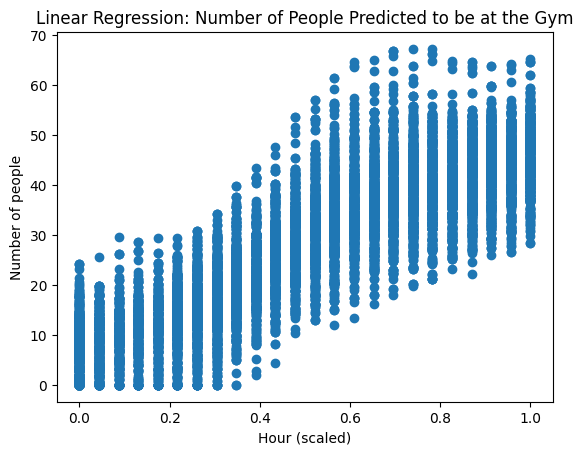

In [ ]:
# Get predictions
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print('Test MSE:',mean_squared_error(y_test, y_test_pred))
print('Train MSE:',mean_squared_error(y_train, y_train_pred))

# Initialize list to keep track of MSEs at different degrees
test_mses = [mean_squared_error(y_test, y_test_pred)]
train_mses = [mean_squared_error(y_train, y_train_pred)]

# Change negative predictions to 0, there cannot be negative people at the gym
y_test_pred[y_test_pred < 0] = 0
y_train_pred[y_train_pred < 0 ] = 0

# Plot
plt.scatter(X_test['hour'],y_test_pred)
plt.xlabel('Hour (scaled)')
plt.ylabel('Number of people')
plt.title('Linear Regression: Number of People Predicted to be at the Gym')
plt.show()

Test MSE (degree 2): 284.791832424171446
Train MSE (degree 2): 281.800818998447255


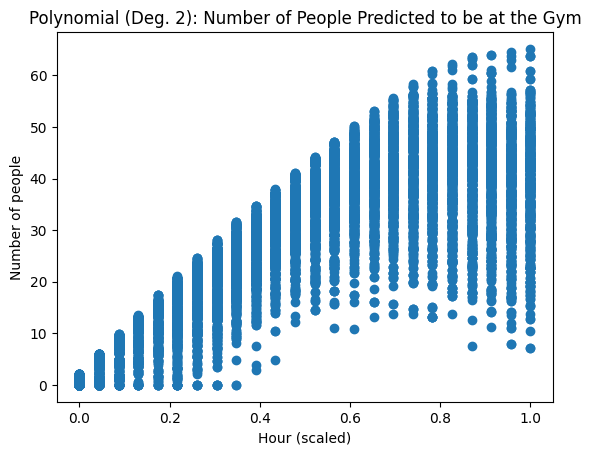

Test MSE (degree 3): 259.825772648314398
Train MSE (degree 3): 257.577830731211463


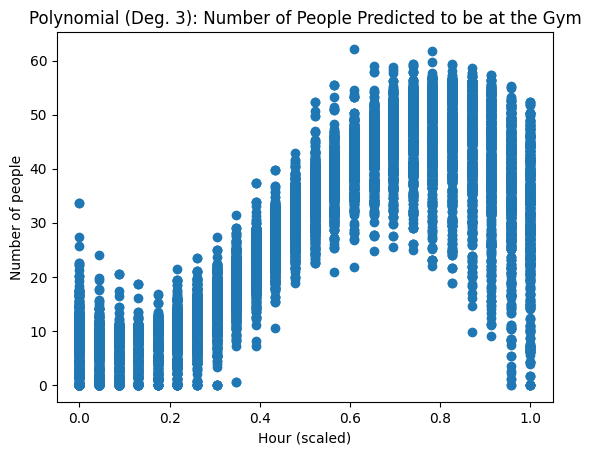

Test MSE (degree 4): 254.100344398310114
Train MSE (degree 4): 250.633661841708118


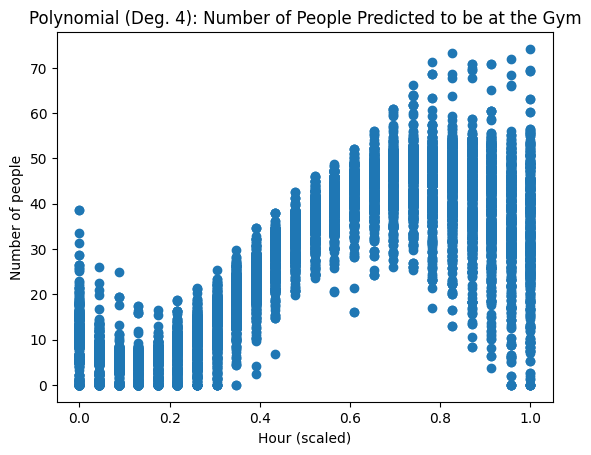

Test MSE (degree 5): 232.539712310630364
Train MSE (degree 5): 230.039056866509782


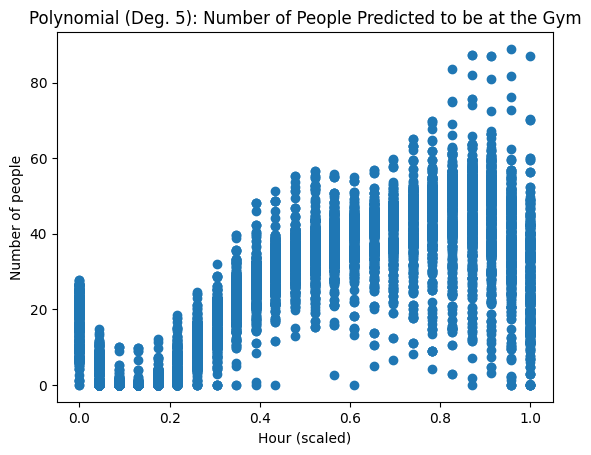

Test MSE (degree 6): 226.502320251246630
Train MSE (degree 6): 223.349815836229624


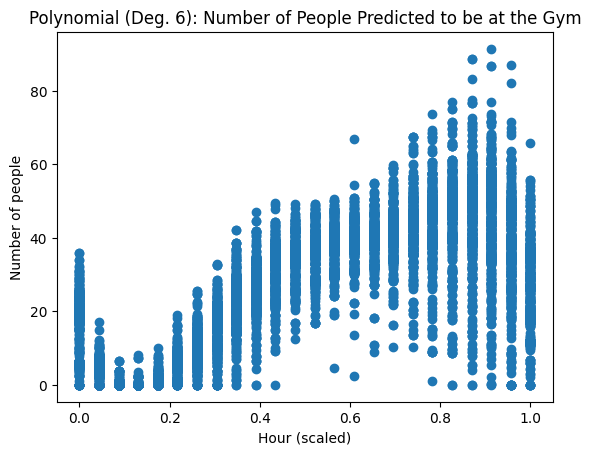

Test MSE (degree 7): 221.601755988310231
Train MSE (degree 7): 217.128987892007359


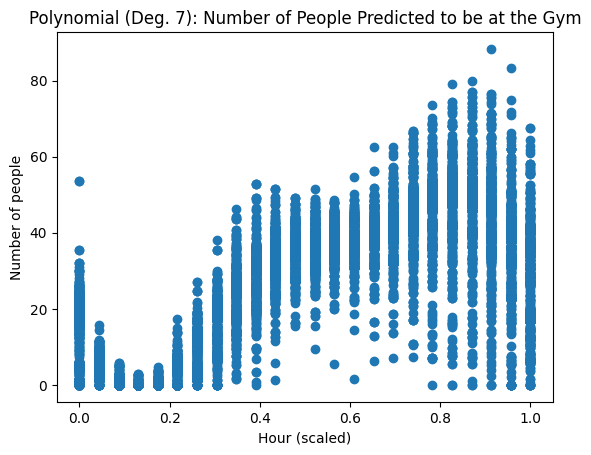

Test MSE (degree 8): 216.839506126229054
Train MSE (degree 8): 212.517014277625037


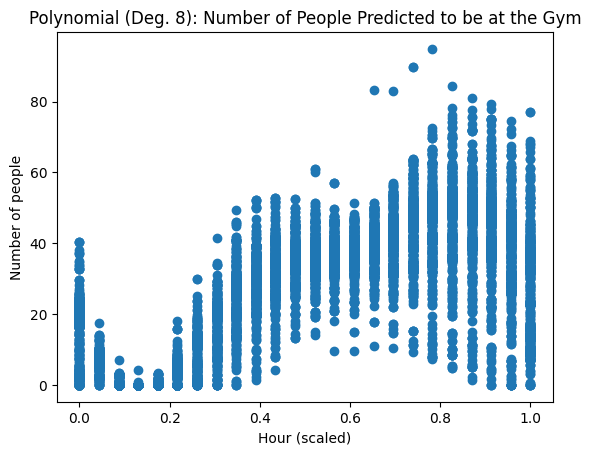

Test MSE (degree 9): 208.063903463295702
Train MSE (degree 9): 205.551973999919312


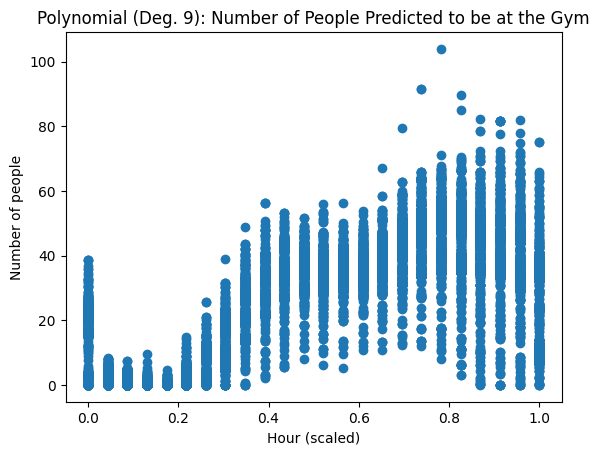

Test MSE (degree 10): 204.642514973803003
Train MSE (degree 10): 202.164199863927536


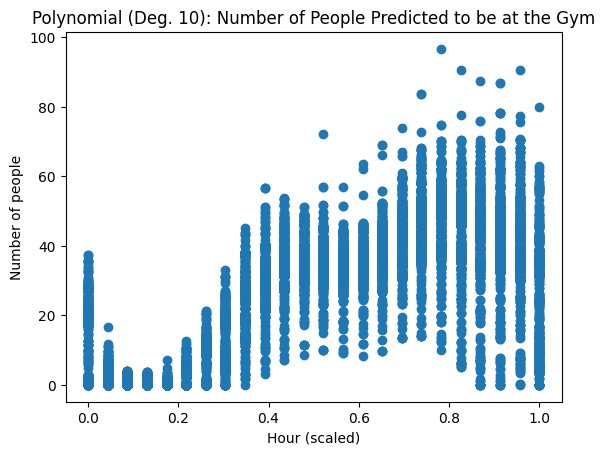

In [ ]:
# Polynomial Regression
for i in range(2,11):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(X_train)

    model = LinearRegression()

    model.fit(X_poly, y_train)

    y_train_pred = model.predict(poly.transform(X_train))
    y_test_pred = model.predict(poly.transform(X_test))

    y_test_pred[y_test_pred < 0] = 0
    y_train_pred[y_train_pred < 0 ] = 0

    test_mses.append(mean_squared_error(y_test, y_test_pred))
    train_mses.append(mean_squared_error(y_train, y_train_pred))

    print('Test MSE (degree '+str(i)+'): %8.15f' % mean_squared_error(y_test, y_test_pred))
    print('Train MSE (degree '+str(i)+'): %8.15f' % mean_squared_error(y_train, y_train_pred))

    plt.scatter(X_test['hour'],y_test_pred)
    plt.xlabel('Hour (scaled)')
    plt.ylabel('Number of people')
    plt.title('Polynomial (Deg. '+str(i)+'): Number of People Predicted to be at the Gym')
    plt.show()

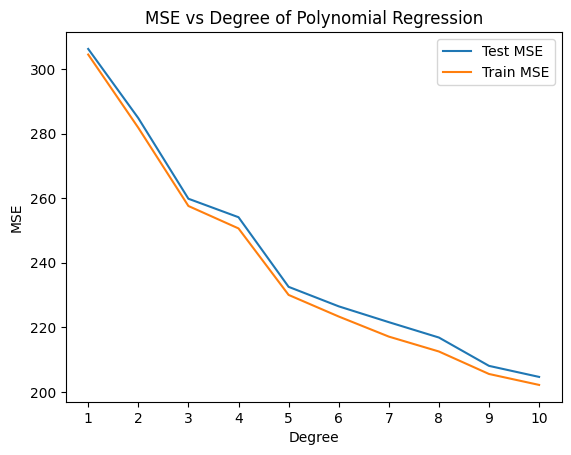

In [ ]:
# Creating plot of degrees vs MSEs
degrees = range(1,11)
mse_df = pd.DataFrame({'Test MSE': test_mses,'Train MSE':train_mses,'Degree': degrees})

plt.plot(mse_df['Degree'],mse_df['Test MSE'],label='Test MSE')
plt.plot(mse_df['Degree'],mse_df['Train MSE'], label='Train MSE')
plt.legend(loc='upper right')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xticks(range(1,11))
plt.title('MSE vs Degree of Polynomial Regression')
plt.show()

Test MSE: 260.95252417965577
Train MSE: 256.6750940747283


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


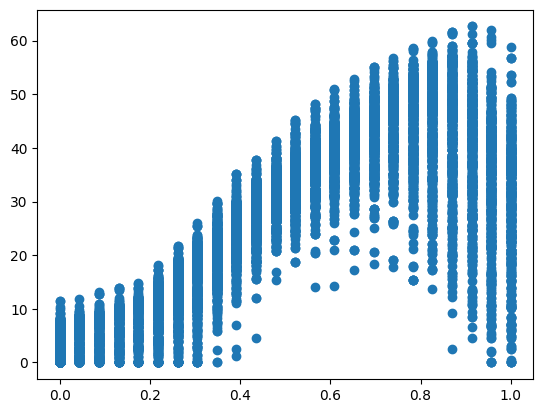

In [ ]:
# Neural Network
# Default hyperparameters
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

y_test_pred_nn = mlp.predict(X_test)
y_train_pred_nn = mlp.predict(X_train)

y_test_pred_nn[y_test_pred_nn < 0] = 0
y_train_pred_nn[y_train_pred_nn < 0 ] = 0

print('Test MSE:',mean_squared_error(y_test, y_test_pred_nn))
print('Train MSE:',mean_squared_error(y_train, y_train_pred_nn))

plt.scatter(X_test['hour'],y_test_pred_nn)

Test MSE: 229.73309446960232
Train MSE: 226.34241410316574


Text(0, 0.5, 'Number of people')

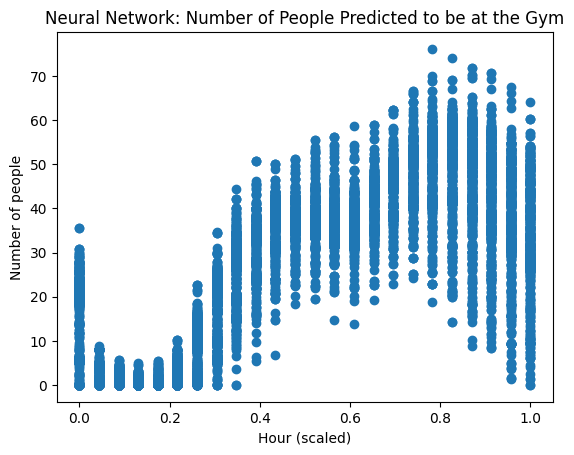

In [ ]:
# Neural Network
# With random search tuned hyperparameters
mlp = MLPRegressor(learning_rate_init = 0.03, max_iter=500)
mlp.fit(X_train, y_train)

y_test_pred_nn = mlp.predict(X_test)
y_train_pred_nn = mlp.predict(X_train)

# Change all predictions less than 0 to be 0
y_test_pred_nn[y_test_pred_nn < 0] = 0
y_train_pred_nn[y_train_pred_nn < 0 ] = 0

print('Test MSE:',mean_squared_error(y_test, y_test_pred_nn))
print('Train MSE:',mean_squared_error(y_train, y_train_pred_nn))

plt.scatter(X_test['hour'],y_test_pred_nn)
plt.title('Neural Network: Number of People Predicted to be at the Gym')
plt.xlabel('Hour (scaled)')
plt.ylabel('Number of people')